In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16,ResNet50,InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import cv2
import os
import tensorflow.image as tfi
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle
import tensorflow_hub as hub

2024-06-19 15:38:30.239621: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 15:38:30.290609: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 15:38:30.291402: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 15:38:31.680912: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/utkarsh-ranjan/Documents/shibata-labs/shibata-lab-pose-estimation/movenet/py3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook im

In [3]:
label = ["nose", "left eye", "right eye", "left ear", "right ear", "left shoulder", "right shoulder", "left elbow", "right elbow", "left wrist", "right wrist", "left hip", "right hip", "left knee", "right knee", "left ankle", "right ankle"]

In [4]:
# Load the input image.
image_path = 'test2.jpg'
image = tf.io.read_file(image_path)
image = tf.compat.v1.image.decode_jpeg(image)
X = tf.expand_dims(image, axis=0)
X = tf.cast(tf.image.resize_with_pad(X, 256, 256), dtype=tf.int32)

In [5]:
# Download the model from TF Hub.
model = hub.load("https://tfhub.dev/google/movenet/multipose/lightning/1")
movenet = model.signatures['serving_default']

In [6]:
outputs = movenet(X)
keypoints = outputs['output_0'].numpy()

In [7]:
keypoints.shape

(1, 6, 56)

In [8]:
max_key,key_val = keypoints[0,:,55].argmax(),keypoints[0,:,55].max()
max_key,key_val

(0, 0.5194456)

In [9]:
max_points = keypoints[0,max_key,:]
max_points = max_points*256
max_points = max_points.astype(float)
max_points

array([1.42388062e+02, 1.44287445e+02, 1.73003403e+02, 1.28104767e+02,
       1.56105331e+02, 1.78981674e+02, 1.29425888e+02, 1.31398880e+02,
       1.82183197e+02, 1.26844566e+02, 1.68801575e+02, 1.54003326e+02,
       1.28070389e+02, 1.15221138e+02, 1.80984482e+02, 1.77809479e+02,
       2.03442688e+02, 1.80469116e+02, 1.71787567e+02, 9.83694687e+01,
       1.26801750e+02, 1.96941483e+02, 2.30545502e+02, 1.59211645e+01,
       1.96858597e+02, 5.46364746e+01, 1.25917030e+02, 1.93993546e+02,
       1.95410599e+02, 9.88033295e+00, 1.95474564e+02, 5.70870743e+01,
       9.47827911e+00, 2.03658493e+02, 1.87871887e+02, 5.21390350e-04,
       1.99485046e+02, 1.17483414e+02, 8.16146203e-04, 1.89665817e+02,
       1.90150955e+02, 6.95791319e-02, 1.90365707e+02, 1.20798309e+02,
       1.18826404e-01, 1.49218811e+02, 1.84735596e+02, 7.84317112e+00,
       1.73618637e+02, 1.62652863e+02, 3.50861812e+00, 9.33503494e+01,
       4.25451660e+01, 1.98121216e+02, 2.41075958e+02, 1.32978073e+02])

In [12]:
keypoints_dict = {}
for i in range(0,len(max_points)-5,3):
    if(max_points[i+2] > 100):
        keypoints_dict[label[i//3]] = [max_points[i],max_points[i+1],max_points[i+2]]

In [14]:
keypoints_dict

{'nose': [142.3880615234375, 144.28744506835938, 173.00340270996094],
 'left eye': [128.10476684570312, 156.10533142089844, 178.98167419433594],
 'right eye': [129.42588806152344, 131.3988800048828, 182.18319702148438],
 'left ear': [126.84456634521484, 168.80157470703125, 154.00332641601562],
 'right ear': [128.0703887939453, 115.22113800048828, 180.98448181152344],
 'left shoulder': [177.80947875976562, 203.44268798828125, 180.4691162109375],
 'right shoulder': [171.78756713867188, 98.36946868896484, 126.80175018310547],
 'right elbow': [196.8585968017578, 54.636474609375, 125.91703033447266]}

In [18]:
def make_pred(img, keypoints_dict, label):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img[0])
    plt.subplot(1, 3, 2)
    plt.imshow(img[0])
    plt.title('Pose')
    plt.axis('off')
    for i in range(13):
        if label[i] in keypoints_dict: 
            plt.scatter(keypoints_dict[label[i]][1],keypoints_dict[label[i]][0],color='green')

    connections = [
        ('nose', 'left eye'), ('left eye', 'left ear'), ('nose', 'right eye'), ('right eye', 'right ear'),
        ('nose', 'left shoulder'), ('left shoulder', 'left elbow'), ('left elbow', 'left wrist'),
        ('nose', 'right shoulder'), ('right shoulder', 'right elbow'), ('right elbow', 'right wrist'),
        ('left shoulder', 'left hip'), ('right shoulder', 'right hip'), ('left hip', 'right hip'),
        ('left hip', 'left knee'), ('right hip', 'right knee')
    ]

    for start_key, end_key in connections:
        if start_key in keypoints_dict and end_key in keypoints_dict:
            start_point = keypoints_dict[start_key][:2]  # Take first two values
            end_point = keypoints_dict[end_key][:2]      # Take first two values
            plt.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], linewidth=2)

    plt.subplot(1, 3, 3)
    plt.imshow((img[0]/255)/255)
    plt.title('Only Pose Image')
    for start_key, end_key in connections:
        if start_key in keypoints_dict and end_key in keypoints_dict:
            start_point = keypoints_dict[start_key][:2]  # Take first two values
            end_point = keypoints_dict[end_key][:2]      # Take first two values
            plt.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], linewidth=2)

In [16]:
img = tf.image.resize_with_pad(image, 256, 256)
img = tf.cast(img, dtype=tf.int32)
img = tf.expand_dims(img, axis=0)
img = img.numpy()

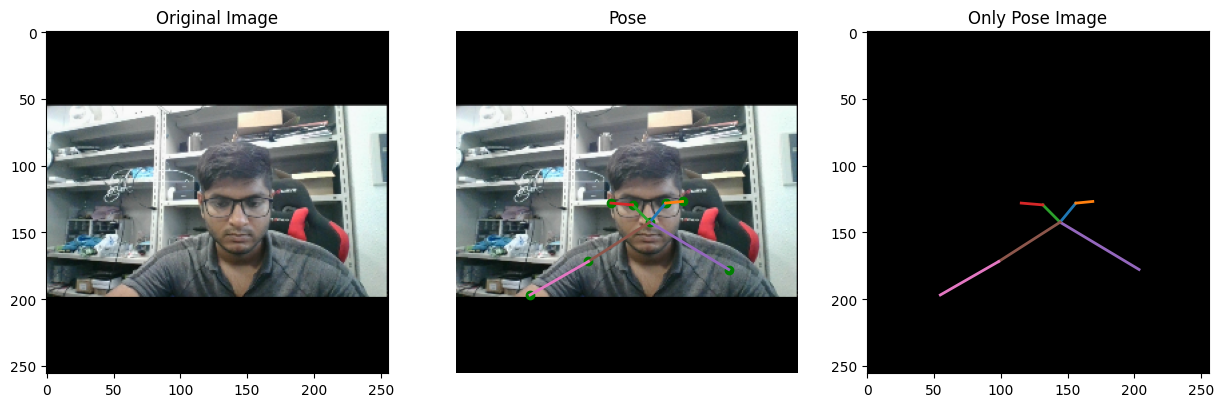

In [19]:
make_pred(img, keypoints_dict, label)